[View in Colaboratory](https://colab.research.google.com/github/DJCordhose/deep-learning-crash-course-notebooks/blob/master/U3-M9-regularization.ipynb)

# Regularization - How to get a decent architecture?

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.22.0


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.1


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0  26783      0  0:00:01 --:--:--  0:00:01 76522


In [0]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [10]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [11]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000
std,17.604333,17.130400,15.250815
min,68.000000,16.000000,1.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,100.000000,84.000000


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
                
def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

In [0]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We have several means of regularization

 _We use a combination of them:_
- reduce capacity of model
- dropout
- batch normalization
- change activation to relu for faster training
- reduce amount of training cycles

## Dropout explained in a funny way

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/dropout-smerty.jpg'>

https://twitter.com/Smerity/status/980175898119778304

### An experimental approach:
- keep adding regularization to make test and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [17]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

dropout = 0.6
model = keras.Sequential()

model.add(Dense(500, name='hidden1', input_dim=2))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [18]:
# reducing batch size might increase overfitting, but might be necessary to reduce memory requirements 
BATCH_SIZE=1000

# reduce this based on what you see in the training history
EPOCHS = 10000

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

CPU times: user 1min 17s, sys: 12 s, total: 1min 29s
Wall time: 1min 8s


In [19]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

900/900 [==============================] - 0s 9us/step


0.7133333086967468

In [20]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

600/600 [==============================] - 0s 8us/step


0.6850000023841858

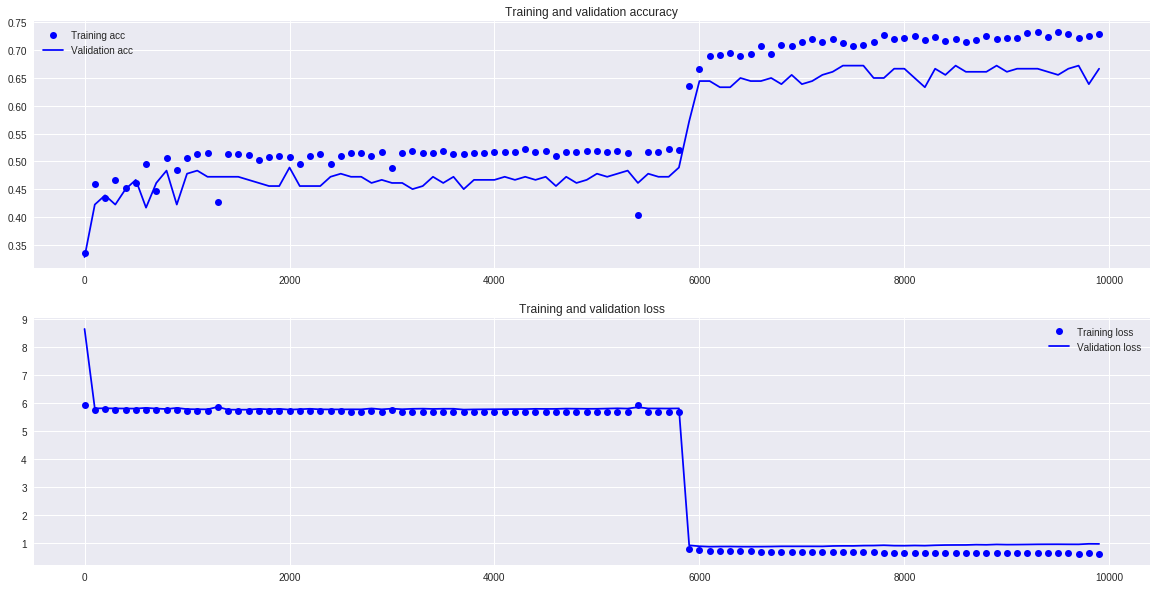

In [21]:
plot_history(history)

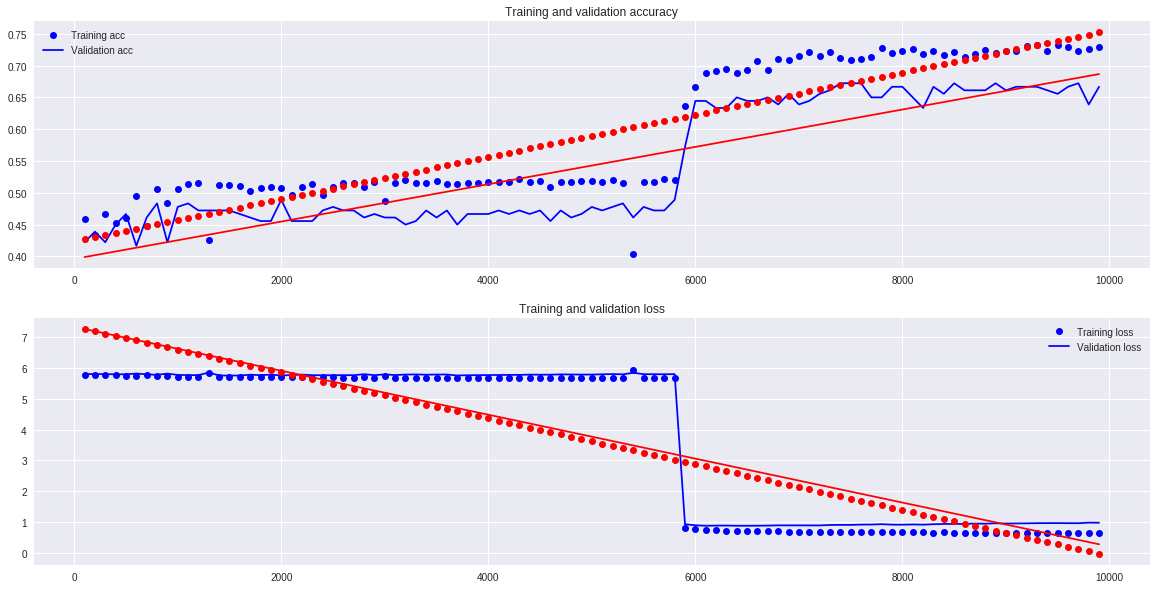

In [27]:
# sometimes it is not so easy if we still have a change, plot a line through the data
plot_history(history, plot_line=True, init_phase_samples=100)

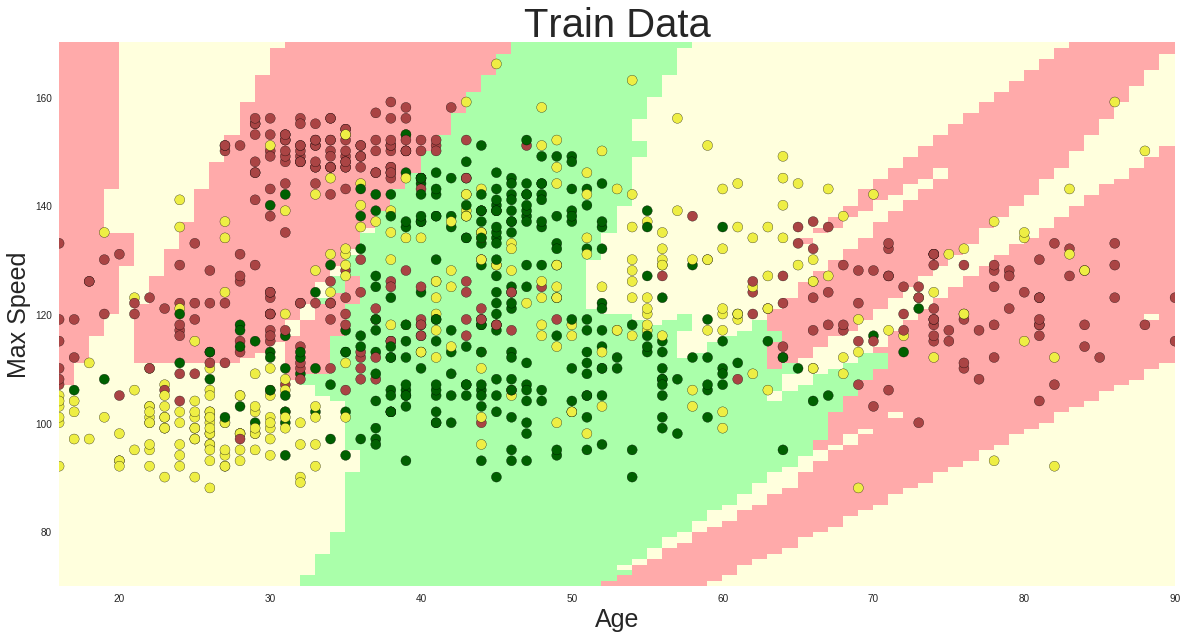

In [23]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

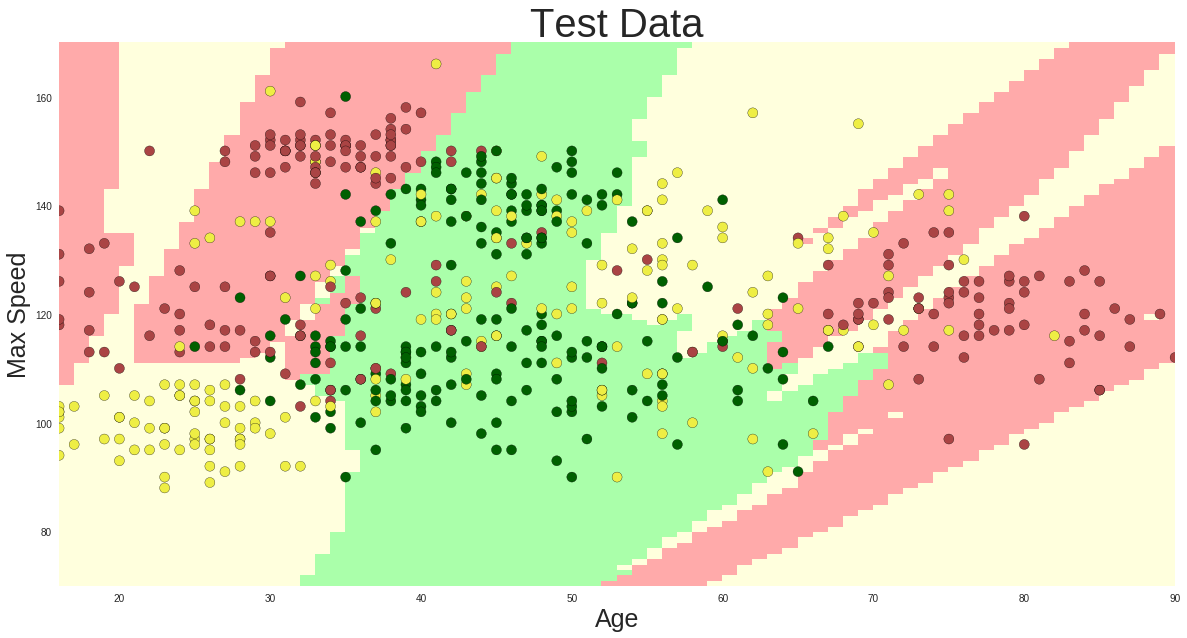

In [24]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")

## When you have a decent model, save it for the next steps

In [0]:
model.save('insurance.h5')

In [26]:
!ls -l insurance.h5

-rw-r--r-- 1 root root 3070424 Sep 23 10:47 insurance.h5
